# Packages and Plot Function

In [1]:
import sys; sys.path.append('..')
import dgl
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from fenics import *
from dolfin import *
from mshr import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dgl.data.utils import load_graphs
from src.utils.to_dgl import fenics_to_graph as to_dgl
from src.utils.gif import gif_generator


def plot_graph(graph):
    plt.figure(figsize=(11, 5))
    plt.subplot(1, 2, 1)
    x = graph.ndata['coords'][:, 0].view(-1).numpy()
    y = graph.ndata['coords'][:, 1].view(-1).numpy()
    value = graph.ndata['value'].view(-1).numpy()
    # Plot Nodes
    plt.scatter(x, y, value)
    # Plot Edges
    src, dst = graph.edges()
    for i in range(len(dst)):
        nodes_x = [x[src[i]], x[dst[i]]]
        nodes_y = [y[src[i]], y[dst[i]]]
        plt.plot(nodes_x, 
                 nodes_y, 
                 color='black', 
                 alpha=0.9, 
                 linewidth=0.6)
    # Apply norm 
    norm = None
    # Mesh on plot or separated
    cax = None
    ax = plt.subplot(1, 2, 2)
    fig = plt.tricontourf(x, y, value, levels=30, norm=norm)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Plot with interpolation
    plt.colorbar(fig, cax=cax)
    

def plot_graph_original(graph, vmin=0, vmax=1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1, 2, 1)
    x = graph.ndata['x'].view(-1).numpy()
    y = graph.ndata['y'].view(-1).numpy()
    value = graph.ndata['value'].view(-1).numpy()
    # Plot Nodes
    plt.scatter(x, y, value)
    # Plot Edges
    src, dst = graph.edges()
    for i in range(len(dst)):
        nodes_x = [x[src[i]], x[dst[i]]]
        nodes_y = [y[src[i]], y[dst[i]]]
        plt.plot(nodes_x, 
                 nodes_y, 
                 color='black', 
                 alpha=0.9, 
                 linewidth=0.6)
    # Apply norm 
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    # Mesh on plot or separated
    cax = None
    ax = plt.subplot(1, 2, 2)
    fig = plt.tricontourf(x, y, value, levels=30, norm=norm)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Plot with interpolation
    plt.colorbar(fig, cax=cax)
    
    
def mark_boundary(graph):
    error = 1e-2
    coords = graph.ndata['coords']
    for i in range(graph.number_of_nodes()):
        if abs(coords[i][0] - 2) < error or abs(coords[i][0] + 2) < error or abs(coords[i][1] - 2) < error or abs(coords[i][1] + 2) < error:
             graph.ndata['is_bdd'][i] = 1
                
def mark_boundary_original(graph):
    error = 1e-2
    graph.ndata['is_bdd'] = torch.zeros(graph.number_of_nodes(), 1)
    for i in range(graph.number_of_nodes()):
        if abs(graph.ndata['x'][i].item() - 2) < error or abs(graph.ndata['x'][i].item() + 2) < error or abs(graph.ndata['y'][i].item() - 2) < error or abs(graph.ndata['y'][i].item() + 2) < error:
             graph.ndata['is_bdd'][i] = 1

Using backend: pytorch


In [2]:
graph_list = load_graphs('../data/gsi2.bin')[0]
print(len(graph_list))

50


# Update Graph

In [3]:
def adaptive_graph(graph1, graph2, update_rate=0.5):
    update_graph = graph1.clone()
    update_graph.ndata['value'] = abs(graph2.ndata['value'] - graph1.ndata['value'])

    mark_boundary_original(update_graph)
    dist_threshold = 1e-1

    vector_list = []
    for i in range(update_graph.number_of_nodes()):
        if update_graph.ndata['is_bdd'][i] > 0.5: 
            vector = torch.tensor([0, 0], dtype=torch.float)
            vector_list.append(vector)
            continue # Boundary Nodes

        vector = torch.tensor([0, 0], dtype=torch.float)
        _, neighbors = update_graph.out_edges([i])

        for j in neighbors:
            if update_graph.ndata['value'][j].item() < update_graph.ndata['value'][i].item():
                continue # Update Smaller Than Src Node
            dist = torch.sqrt((update_graph.ndata['x'][j] - update_graph.ndata['x'][i]) ** 2 + (update_graph.ndata['x'][i] - update_graph.ndata['x'][i]) ** 2)
            if dist < dist_threshold:
                continue # Two Nodes Too Close
            diff = update_graph.ndata['value'][j].item() - update_graph.ndata['value'][i].item()
            update_x = update_rate * (update_graph.ndata['x'][j] - update_graph.ndata['x'][i]) * diff / dist
            update_y = update_rate * (update_graph.ndata['y'][j] - update_graph.ndata['y'][i]) * diff / dist
            vector[0] += update_x
            vector[1] += update_y

        vector_list.append(vector)
    
    return vector_list

In [4]:
def solve_function(mesh):
    start = 0
    stop = 1
    step = 60
    dt = stop/step
    function_space = FunctionSpace(mesh, 'P', 1)

    u0 = Expression('exp(-1*pow(x[0]+2,2)-1*pow(x[1]+2,2))', degree=2)
    ud = Expression('0', degree=2)
    f = Expression('0', degree=2)

    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(function_space, ud, boundary)
    un = interpolate(u0, function_space)

    u = TrialFunction(function_space)
    v = TestFunction(function_space)
    F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (un + dt * f) * v * dx
    a, L = lhs(F), rhs(F)

    u = Function(function_space)
    t = 0
    graphs = []
    for _ in range(step):
        t += dt
        solve(a == L, u, bc)
        un.assign(u)
        graphs.append(to_dgl(function=u, mesh=mesh))
    
    return graphs

In [5]:
# Epoch Test
mesh = generate_mesh(Rectangle(Point(-2, -2), Point(2, 2)), 4)
mesh_list = []
plot_graph_list = []
adaptive_rate = 0.2
steps = 60
for epoch in range(steps):
    graph_list = solve_function(mesh)
    vector_list = adaptive_graph(graph_list[epoch], graph_list[epoch+1], adaptive_rate)
#     mesh.coordinates() = mesh.coordinates() + vector_list
    for i in range(mesh.coordinates().shape[0]):
        mesh.coordinates()[i][0] += vector_list[i][0]
        mesh.coordinates()[i][1] += vector_list[i][1]
    plot_graph_list.append(graph_list[epoch])
    mesh_list.append(mesh)
    adaptive_rate += 0.2

RuntimeError: Invalid parameter: form_compiler

In [173]:
len(plot_graph_list)

33

In [ ]:
for i in range(steps):
    plot_graph_original(plot_graph_list[i], vmax=0.9)
    plt.savefig(f'../fig/{i}.png')

In [2]:
gif_generator('../fig/gaussian_center/', '../fig/gaussian_center.gif')

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 34.75it/s]


In [68]:
mesh = generate_mesh(Rectangle(Point(-2, -2), Point(2, 2)), 4)

start = 0
stop = 1
step = 60
dt = stop/step
function_space = FunctionSpace(mesh, 'P', 1)

u0 = Expression('0', degree=2)
ud = Expression('0', degree=2)
f = Expression('0', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(function_space, ud, boundary)
un = interpolate(u0, function_space)

u = TrialFunction(function_space)
v = TestFunction(function_space)
F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (un + dt * f) * v * dx
a, L = lhs(F), rhs(F)

u = Function(function_space)
t = 0
graphs = []
for _ in range(step):
    t += dt
    solve(a == L, u, bc)
    un.assign(u)
    graphs.append(to_dgl(function=u, mesh=mesh))

RuntimeError: Invalid parameter: form_compiler

# Trash Bin

In [98]:
update_vector = adapive_graph(graphs[0], graphs[1])
for i in range(mesh.coordinates().shape[0]):
    mesh.coordinates()[i][0] += update_vector[i][0]
    mesh.coordinates()[i][1] += update_vector[i][1]

In [95]:
start = 0
stop = 1
step = 2
dt = stop/step
mesh = generate_mesh(Rectangle(Point(-2, -2), Point(2, 2)), 4)
function_space = FunctionSpace(mesh, 'P', 1)

u0 = Expression('exp(-1*pow(x[0],2)-1*pow(x[1],2))', degree=2)
ud = Expression('0', degree=2)
f = Expression('0', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(function_space, ud, boundary)
un = interpolate(u0, function_space)

u = TrialFunction(function_space)
v = TestFunction(function_space)
F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (un + dt * f) * v * dx
a, L = lhs(F), rhs(F)

u = Function(function_space)
t = 0
graphs = []
for _ in range(step):
    t += dt
    solve(a == L, u, bc)
    un.assign(u)
    graphs.append(to_dgl(function=u, mesh=mesh))

Solving linear variational problem.
Solving linear variational problem.


/home/cbhua/.local/lib/python3.9/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


<class 'numpy.ndarray'>
(16, 2)


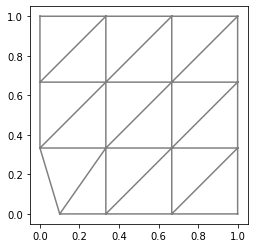

In [23]:
# DGL Graph to FEniCS Mesh
mesh_test = UnitSquareMesh(3, 3)
print(type(mesh_test.coordinates()))
print(mesh_test.coordinates().shape)
mesh_test.coordinates()[0, 0] += 0.1
plot(mesh_test)

In [39]:
graph1 = graph_list[0].clone()
graph2 = graph_list[1].clone()
update_graph = graph1.clone()
update_graph.ndata['value'] = abs(graph2.ndata['value'] - graph1.ndata['value'])
update_rate = 5

mark_boundary(update_graph)
dist_threshold = 1e-1

vector_list = []
for i in range(update_graph.number_of_nodes()):
    if update_graph.ndata['is_bdd'][i] > 0.5: 
        vector = torch.tensor([0, 0], dtype=torch.float)
        vector_list.append(vector)
        continue # Boundary Nodes
    
    coords_src = update_graph.ndata['coords'][i]
    vector = torch.tensor([0, 0], dtype=torch.float)
    _, neighbors = update_graph.out_edges([i])
    
    for j in neighbors:
        if update_graph.ndata['value'][j][0] < update_graph.ndata['value'][i][0]:
            continue # Update Smaller Than Src Node
        coords_dst = update_graph.ndata['coords'][j]
        dist = torch.sqrt((coords_dst[0] - coords_src[0]) ** 2 + (coords_dst[1] - coords_src[1]) ** 2)
        if dist < dist_threshold:
            continue # Two Nodes Too Close
        diff = update_graph.ndata['value'][j][0] - update_graph.ndata['value'][i][0]
        update_x = update_rate * (coords_dst[0] - coords_src[0]) * diff / dist
        update_y = update_rate * (coords_dst[1] - coords_src[1]) * diff / dist
        vector[0] += update_x
        vector[1] += update_y

    vector_list.append(vector)

for i in range(graph2.number_of_nodes()):
    if update_graph.ndata['is_bdd'][i] > 0.5: 
        continue # Boundary Nodes
    graph2.ndata['coords'][i][0] += vector_list[i][0]
    graph2.ndata['coords'][i][1] += vector_list[i][1]

In [87]:
mesh = generate_mesh(Rectangle(Point(-2, -2), Point(2, 2)), 4)
print(type(mesh))
function_space = FunctionSpace(mesh, 'P', 1)
print(type(mesh))

<class 'dolfin.cpp.mesh.Mesh'>
<class 'dolfin.cpp.mesh.Mesh'>


In [91]:
mesh.coordinates()[0]

array([-2.,  2.])

In [20]:
print(type(graphs))
print(len(graphs))
print(type(graphs[0]))
mark_boundary_original(graphs[0])
print(graphs[0])

<class 'list'>
2
<class 'dgl.heterograph.DGLHeteroGraph'>
-2.0
Graph(num_nodes=35, num_edges=172,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.float32), 'y': Scheme(shape=(), dtype=torch.float32), 'value': Scheme(shape=(), dtype=torch.float32), 'is_bdd': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})


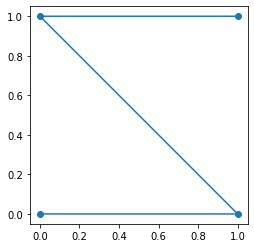

In [33]:
nodes = np.array([[0., 0.],
                  [1., 0.],
                  [0., 1.],
                  [1., 1.]])
cells = np.array([[0,3]], dtype=np.uintp)

mesh = Mesh()
editor = MeshEditor()
# editor.open(mesh, 'triangle', 2, 2) # (mesh, topological dim, geometrical dim)
editor.open(mesh, 'interval', 1, 2) 
editor.init_vertices(4)
editor.init_cells(1)

[editor.add_vertex(i, n) for i, n in enumerate(nodes)]
[editor.add_cell(i, n) for i, n in enumerate(cells)]
editor.close()

plot(mesh)

In [32]:
print(graph.ndata['is_bdd'])
mark_boundary(graph)
print(graph.ndata['is_bdd'])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       dtype=torch.float64)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       dtype=torch.float64)


In [ ]:
graph1 = graph_list[0]
graph2 = graph_list[1]

mark_boundary(graph1)
mark_boundary(graph2)

for i in range(graph1.number_of_nodes()):
    # Boundary nodes
    if graph1.ndata['is_bdd'][i] > 0.5:
        continue
    
    coords = graph1.ndata['coords'][i]
    vector = [0, 0]
    neighbors = graph.out_edges([i])
    
    for j in range(neighbors):
        pass